### <sapn style="color:Teal"> __DIFFERENTIAL ABUNDANCE ANALYSIS__

In [1]:
# LOADING REQUiRED PACKAGES AND LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from scipy.spatial import procrustes
import tqdm
from tqdm.notebook import tqdm  # ✅ Use this in Jupyter for clean nested bars
from skbio.stats.distance import permanova
from joblib import Parallel, delayed
import os
import multiprocessing
import json
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings("ignore", message="The result contains negative eigenvalues.*")


In [2]:
df_genus= pd.read_csv('/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmrepo_curated_data/disease_genus_abundance.txt', sep = '\t')
df_species = pd.read_csv('/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmrepo_curated_data/disease_species_abundance.txt', sep = '\t')

In [3]:
# IMPORT DISEASE DICTIONARY

# Load disease code to name mapping
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/resources/disease_dict.json", "r") as f:
    disease_dict = json.load(f)

## __FILTERING__

__FILTERING LOGIC APPLIED__
The filtering strategy applied to the genus-level and species-level microbiome dataset is designed to ensure both statistical robustness and biological relevance in downstream analyses. First, unknown taxa lacking proper classification (i.e., those with `ncbi_taxon_id == -1`) are removed to maintain interpretability. Next, disease categories with fewer than **__60__** unique samples are excluded to ensure adequate statistical power for meaningful comparisons with the healthy group. Following sample-level filtering, taxon-level filtering is applied using a two-tiered approach based on prevalence and abundance. The **primary filter** retains only those taxa that are present in more than 0.1% of the total samples and have a minimum relative abundance greater than 0.001, effectively eliminating ultra-rare and consistently low-abundance taxa that likely represent noise. To complement this, a **secondary filter** is used to preserve biologically important taxa that might otherwise be excluded — it retains any taxon with either a prevalence above 1% or a minimum abundance exceeding 0.01. This dual-filtering strategy balances noise reduction with the need to preserve taxa that may be rare but highly abundant in specific contexts, such as disease-specific blooms or pathogenic organisms. Overall, the approach enhances the clarity, reliability, and interpretability of differential abundance and diversity analyses.

To ensure that only biologically meaningful taxa are retained for downstream analysis, we apply a disease-specific filtering strategy based on both prevalence and maximum abundance. For each disease group, we evaluate every taxon independently. A taxon is retained within a disease group only if it meets two conditions: (1) it is present in at least 10% of samples from that disease (i.e., prevalence ≥ 10%), and (2) it reaches a relative abundance greater than 1% in at least one sample from that group. This filtering is done within each disease, rather than globally, ensuring that a taxon is only included where it shows meaningful presence and abundance. As a result, taxa that are rare, inconsistently present, or only appear with negligible abundance are excluded from each disease group individually, reducing noise and improving the biological relevance of the dataset.
___


In [4]:
# GENUS LEVEL MONTE CARLO PERMUTATIION FOR IDENTIFICATION OF DIFFERENTAILLY ABUNDANT TAXA - GENUS LEVEL
# ───────────────────────────────────────────────────────────────
# FILTERING CRITERIA
# ───────────────────────────────────────────────────────────────
prevalence_threshold = 10  # in percentage
abundance_threshold = 1    # in percentage

print("══════════════════════════════════════════════════════════════")
print("MICROBIOME TAXON FILTERING — DISEASE-SPECIFIC LOGIC")
print("──────────────────────────────────────────────────────────────")
print(f"Filtering Criteria:")
print(f" - Prevalence ≥ {prevalence_threshold}%")
print(f" - Max Relative Abundance > {abundance_threshold}%")
print(" - Filtering is done within each disease group independently")
print("══════════════════════════════════════════════════════════════\n")

# ───────────────────────────────────────────────────────────────
# Step 1: Remove unknown taxa
# ───────────────────────────────────────────────────────────────
df_genus_cleaned = df_genus[df_genus['ncbi_taxon_id'] != -1].copy()
print(f"[Step 1] Removed unknown taxa: {df_genus.shape[0] - df_genus_cleaned.shape[0]} rows removed")

# ───────────────────────────────────────────────────────────────
# Step 2: Remove diseases with <30 samples
# ───────────────────────────────────────────────────────────────
disease_sample_counts = (
    df_genus_cleaned[['loaded_uid', 'disease']]
    .drop_duplicates()
    .groupby('disease')
    .size()
)

valid_diseases = disease_sample_counts[disease_sample_counts >= 30].index
df_genus_cleaned = df_genus_cleaned[df_genus_cleaned['disease'].isin(valid_diseases)].copy()

print(f"[Step 2] Valid diseases retained (≥30 samples): {len(valid_diseases)} diseases")
print(f"[Step 2] Remaining rows after disease filtering: {df_genus_cleaned.shape[0]}")

# ───────────────────────────────────────────────────────────────
# Step 3: Group by disease and taxon, calculate prevalence and max abundance
# ───────────────────────────────────────────────────────────────
grouped = (
    df_genus_cleaned
    .groupby(['disease', 'ncbi_taxon_id'])
    .agg(
        prevalence=('relative_abundance', lambda x: (x > 0).sum() / x.shape[0] * 100),
        max_abundance=('relative_abundance', 'max')
    )
    .reset_index()
)

print(f"[Step 3] Number of (disease, taxon) pairs before filtering: {grouped.shape[0]}")

# ───────────────────────────────────────────────────────────────
# Step 4: Apply primary filter (prevalence ≥ 10% and max_abundance > 1)
# ───────────────────────────────────────────────────────────────
primary_mask = (grouped["prevalence"] >= prevalence_threshold) & (grouped["max_abundance"] > abundance_threshold)
grouped_filtered = grouped[primary_mask]

print(f"[Step 4] (Disease, taxon) pairs retained after filtering: {grouped_filtered.shape[0]}")
print(f"[Step 4] Unique taxa retained: {grouped_filtered['ncbi_taxon_id'].nunique()}")
print(f"[Step 4] Diseases with retained taxa: {grouped_filtered['disease'].nunique()}")

# ───────────────────────────────────────────────────────────────
# Step 5: Filter the full dataset to retain only the valid (disease, taxon) pairs
# ───────────────────────────────────────────────────────────────
df_genus_retained = df_genus_cleaned.merge(
    grouped_filtered[['disease', 'ncbi_taxon_id']],
    on=['disease', 'ncbi_taxon_id'],
    how='inner'
)

print(f"[Step 5] Final retained rows: {df_genus_retained.shape[0]}")

# ───────────────────────────────────────────────────────────────
# Step 6: Compare number of unique taxa per disease: before vs. after
# ───────────────────────────────────────────────────────────────
before_counts = (
    df_genus_cleaned.groupby("disease")["ncbi_taxon_id"]
    .nunique()
    .rename("taxa_before_filtering")
)

after_counts = (
    df_genus_retained.groupby("disease")["ncbi_taxon_id"]
    .nunique()
    .rename("taxa_after_filtering")
)

comparison_df = pd.concat([before_counts, after_counts], axis=1).fillna(0).astype(int)

print("\n[Step 6] Number of unique taxa per disease: BEFORE vs AFTER filtering")
print(comparison_df.sort_values("taxa_before_filtering", ascending=False))


══════════════════════════════════════════════════════════════
MICROBIOME TAXON FILTERING — DISEASE-SPECIFIC LOGIC
──────────────────────────────────────────────────────────────
Filtering Criteria:
 - Prevalence ≥ 10%
 - Max Relative Abundance > 1%
 - Filtering is done within each disease group independently
══════════════════════════════════════════════════════════════

[Step 1] Removed unknown taxa: 30186 rows removed
[Step 2] Valid diseases retained (≥30 samples): 66 diseases
[Step 2] Remaining rows after disease filtering: 2249445
[Step 3] Number of (disease, taxon) pairs before filtering: 45710
[Step 4] (Disease, taxon) pairs retained after filtering: 5581
[Step 4] Unique taxa retained: 520
[Step 4] Diseases with retained taxa: 66
[Step 5] Final retained rows: 1449781

[Step 6] Number of unique taxa per disease: BEFORE vs AFTER filtering
         taxa_before_filtering  taxa_after_filtering
disease                                             
D006262                   1613         

Diseases:   0%|          | 0/65 [00:00<?, ?it/s]

Taxa in D003924:   0%|          | 0/110 [00:00<?, ?it/s]

Taxa in D003093:   0%|          | 0/151 [00:00<?, ?it/s]

Taxa in D003967:   0%|          | 0/129 [00:00<?, ?it/s]

Taxa in D003424:   0%|          | 0/126 [00:00<?, ?it/s]

Taxa in D006973:   0%|          | 0/46 [00:00<?, ?it/s]

Taxa in D007234:   0%|          | 0/58 [00:00<?, ?it/s]

Taxa in D015212:   0%|          | 0/131 [00:00<?, ?it/s]

Taxa in D015497:   0%|          | 0/75 [00:00<?, ?it/s]

Taxa in D043183:   0%|          | 0/146 [00:00<?, ?it/s]

Taxa in D007230:   0%|          | 0/62 [00:00<?, ?it/s]

Taxa in D065626:   0%|          | 0/61 [00:00<?, ?it/s]

Taxa in D001321:   0%|          | 0/78 [00:00<?, ?it/s]

Taxa in D012778:   0%|          | 0/69 [00:00<?, ?it/s]

Taxa in D003922:   0%|          | 0/37 [00:00<?, ?it/s]

Taxa in D003015:   0%|          | 0/163 [00:00<?, ?it/s]

Taxa in D006678:   0%|          | 0/51 [00:00<?, ?it/s]

Taxa in D014607:   0%|          | 0/42 [00:00<?, ?it/s]

Taxa in D013274:   0%|          | 0/121 [00:00<?, ?it/s]

Taxa in D011565:   0%|          | 0/31 [00:00<?, ?it/s]

Taxa in D050177:   0%|          | 0/35 [00:00<?, ?it/s]

Taxa in D009765:   0%|          | 0/76 [00:00<?, ?it/s]

Taxa in D006515:   0%|          | 0/39 [00:00<?, ?it/s]

Taxa in D003920:   0%|          | 0/107 [00:00<?, ?it/s]

Taxa in D024821:   0%|          | 0/40 [00:00<?, ?it/s]

Taxa in D016360:   0%|          | 0/56 [00:00<?, ?it/s]

Taxa in D000855:   0%|          | 0/37 [00:00<?, ?it/s]

Taxa in D007676:   0%|          | 0/50 [00:00<?, ?it/s]

Taxa in D008545:   0%|          | 0/69 [00:00<?, ?it/s]

Taxa in D003108:   0%|          | 0/88 [00:00<?, ?it/s]

Taxa in D003248:   0%|          | 0/139 [00:00<?, ?it/s]

Taxa in D003550:   0%|          | 0/64 [00:00<?, ?it/s]

Taxa in D015179:   0%|          | 0/210 [00:00<?, ?it/s]

Taxa in D000236:   0%|          | 0/83 [00:00<?, ?it/s]

Taxa in D019337:   0%|          | 0/94 [00:00<?, ?it/s]

Taxa in D016918:   0%|          | 0/36 [00:00<?, ?it/s]

Taxa in D000067011:   0%|          | 0/48 [00:00<?, ?it/s]

Taxa in D001249:   0%|          | 0/48 [00:00<?, ?it/s]

Taxa in D054198:   0%|          | 0/95 [00:00<?, ?it/s]

Taxa in D001714:   0%|          | 0/118 [00:00<?, ?it/s]

Taxa in D001172:   0%|          | 0/43 [00:00<?, ?it/s]

Taxa in D001943:   0%|          | 0/49 [00:00<?, ?it/s]

Taxa in D013167:   0%|          | 0/39 [00:00<?, ?it/s]

Taxa in D008103:   0%|          | 0/69 [00:00<?, ?it/s]

Taxa in D001327:   0%|          | 0/125 [00:00<?, ?it/s]

Taxa in D008107:   0%|          | 0/73 [00:00<?, ?it/s]

Taxa in D013959:   0%|          | 0/133 [00:00<?, ?it/s]

Taxa in D007410:   0%|          | 0/115 [00:00<?, ?it/s]

Taxa in D008881:   0%|          | 0/127 [00:00<?, ?it/s]

Taxa in D007674:   0%|          | 0/71 [00:00<?, ?it/s]

Taxa in D008171:   0%|          | 0/122 [00:00<?, ?it/s]

Taxa in D002446:   0%|          | 0/74 [00:00<?, ?it/s]

Taxa in D003863:   0%|          | 0/106 [00:00<?, ?it/s]

Taxa in D012559:   0%|          | 0/105 [00:00<?, ?it/s]

Taxa in D000067877:   0%|          | 0/94 [00:00<?, ?it/s]

Taxa in D004827:   0%|          | 0/63 [00:00<?, ?it/s]

Taxa in D001289:   0%|          | 0/92 [00:00<?, ?it/s]

Taxa in D002318:   0%|          | 0/87 [00:00<?, ?it/s]

Taxa in D014376:   0%|          | 0/42 [00:00<?, ?it/s]

Taxa in D012400:   0%|          | 0/53 [00:00<?, ?it/s]

Taxa in D005764:   0%|          | 0/68 [00:00<?, ?it/s]

Taxa in D037841:   0%|          | 0/67 [00:00<?, ?it/s]

Taxa in D016640:   0%|          | 0/53 [00:00<?, ?it/s]

Taxa in D006111:   0%|          | 0/35 [00:00<?, ?it/s]

Taxa in D050031:   0%|          | 0/38 [00:00<?, ?it/s]

Taxa in D013964:   0%|          | 0/45 [00:00<?, ?it/s]

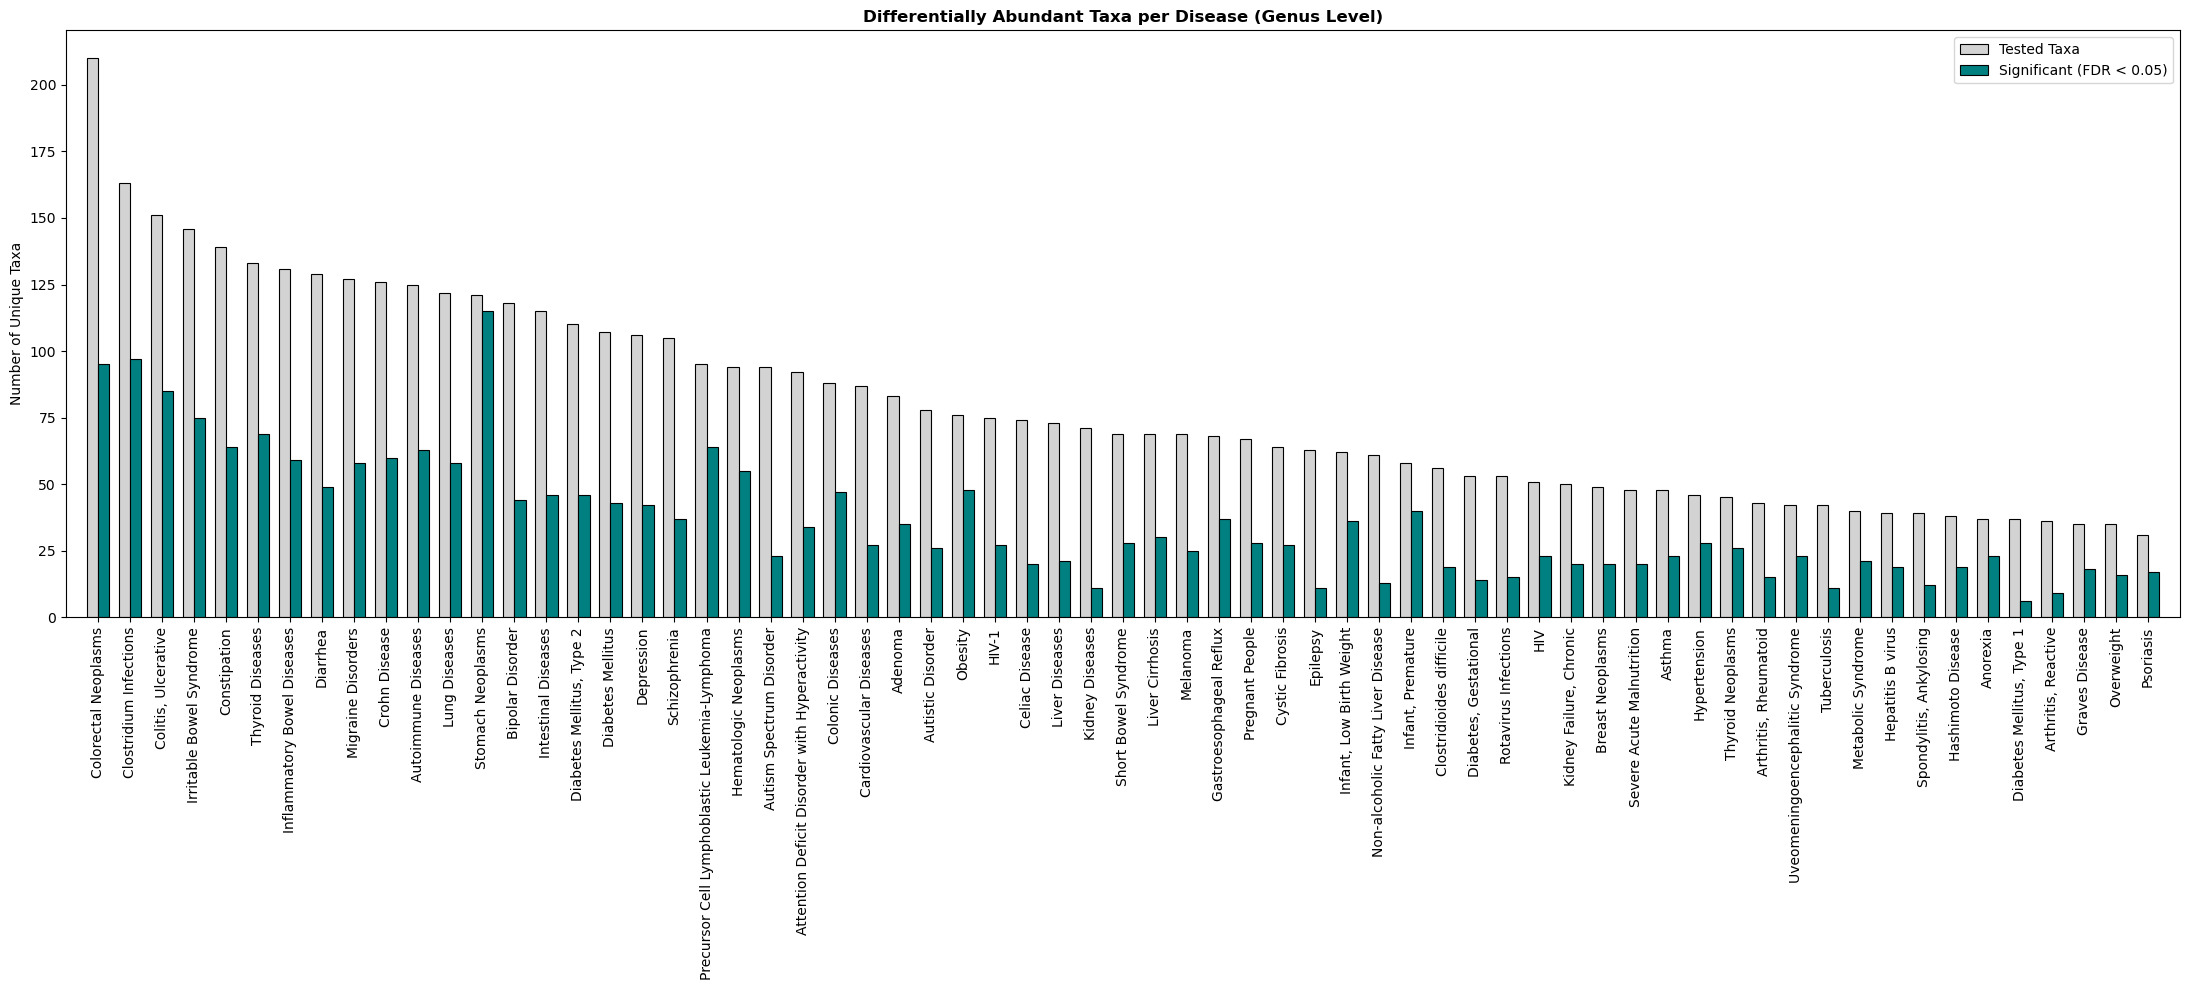

✅ PERMUTATION TESTING COMPLETE
• Total diseases tested: 65
• Total (disease, taxon) pairs tested: 5207
• Total significant pairs (FDR < 0.05): 2335
• Shape of df_genus_significant: (416120, 4)
• Unique significant taxa: 387
• Diseases with significant taxa: 65
📁 Saved significant genus-level taxa to 'significant_genus_taxa.txt'


,n_taxa_tested,n_significant
disease,,
D015179,210,95
D003015,163,97
D003093,151,85
D043183,146,75
D003248,139,64
...,...,...
D003922,37,6
D016918,36,9
D006111,35,18


,taxon,disease,p_value,mean_healthy,mean_disease,diff_mean,p_adj
5166,841,D013964,0.000999,1.004818,2.941188,1.936370,0.003296
5106,33042,D006111,0.000999,0.409043,1.349840,0.940798,0.003296
5108,44748,D006111,0.000999,0.035827,0.257331,0.221504,0.003296
2215,2132,D003108,0.000999,0.065456,0.742960,0.677504,0.003296
2216,2172,D003108,0.000999,0.312975,1.862007,1.549033,0.003296
...,...,...,...,...,...,...,...
5140,33042,D050031,1.000000,1.611750,1.020060,-0.591689,1.000000
81,1573535,D003924,0.988012,0.101011,0.101607,0.000596,1.000000
55,547,D003924,1.000000,0.171584,0.080214,-0.091370,1.000000
65,150022,D003924,0.987013,0.004954,0.005821,0.000867,1.000000


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from tqdm.notebook import tqdm
import seaborn as sns

# ---------------------------
# Configuration
# ---------------------------
HEALTHY_CODE = "D006262"
N_PERMUTATIONS = 1000
RANDOM_SEED = 42

# ---------------------------
# Permutation Test Function
# ---------------------------
def permutation_test(x, y, num_permutations=N_PERMUTATIONS, stat_func=np.mean):
    observed = stat_func(y) - stat_func(x)
    combined = np.concatenate([x, y])
    count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_x = combined[:len(x)]
        new_y = combined[len(x):]
        perm_stat = stat_func(new_y) - stat_func(new_x)
        if abs(perm_stat) >= abs(observed):
            count += 1
    return (count + 1) / (num_permutations + 1)

# ---------------------------
# Prepare Data
# ---------------------------
disease_codes_genus = df_genus_retained['disease'].unique()
disease_codes_genus = [d for d in disease_codes_genus if d != HEALTHY_CODE]

healthy_df_genus = df_genus_retained[df_genus_retained['disease'] == HEALTHY_CODE]
healthy_uids_genus = healthy_df_genus['loaded_uid'].unique()

# ---------------------------
# Run Permutation Testing
# ---------------------------
results_genus = []
rng = np.random.default_rng(RANDOM_SEED)

for disease_code in tqdm(disease_codes_genus, desc="Diseases", position=0):
    disease_df_genus = df_genus_retained[df_genus_retained['disease'] == disease_code]
    disease_uids_genus = disease_df_genus['loaded_uid'].unique()
    disease_taxa_genus = disease_df_genus['ncbi_taxon_id'].unique()

    for taxon in tqdm(disease_taxa_genus, desc=f"Taxa in {disease_code}", position=1, leave=False):
        disease_series = disease_df_genus[disease_df_genus['ncbi_taxon_id'] == taxon].set_index('loaded_uid')['relative_abundance']
        healthy_series = healthy_df_genus[healthy_df_genus['ncbi_taxon_id'] == taxon].set_index('loaded_uid')['relative_abundance']

        disease_vals = disease_series.reindex(disease_uids_genus, fill_value=0).values
        healthy_vals = healthy_series.reindex(healthy_uids_genus, fill_value=0).values

        # Skip if absent in both groups
        if np.all(disease_vals == 0) and np.all(healthy_vals == 0):
            continue

        # Skip if present in healthy but completely absent in disease
        if np.any(healthy_vals > 0) and np.all(disease_vals == 0):
            continue

        # Downsample to equal sample size
        if len(healthy_vals) > len(disease_vals):
            healthy_vals = rng.choice(healthy_vals, size=len(disease_vals), replace=False)
        elif len(disease_vals) > len(healthy_vals):
            disease_vals = rng.choice(disease_vals, size=len(healthy_vals), replace=False)

        # Run permutation test
        p_val = permutation_test(healthy_vals, disease_vals)

        # Store result
        results_genus.append({
            'taxon': taxon,
            'disease': disease_code,
            'p_value': p_val,
            'mean_healthy': np.mean(healthy_vals),
            'mean_disease': np.mean(disease_vals),
            'diff_mean': np.mean(disease_vals) - np.mean(healthy_vals)
        })

# ---------------------------
# Process Results
# ---------------------------
results_df_genus = pd.DataFrame(results_genus)

if not results_df_genus.empty:
    # FDR correction
    results_df_genus['p_adj'] = multipletests(results_df_genus['p_value'], method='fdr_bh')[1]

    # Summary Table
    summary_table_genus = (
        results_df_genus
        .groupby("disease")
        .agg(
            n_taxa_tested=("taxon", "nunique"),
            n_significant=("p_adj", lambda x: (x < 0.05).sum())
        )
        .sort_values("n_taxa_tested", ascending=False)
    )

    # ---------------------------
    # Plot with disease names
    # ---------------------------
    plot_df_genus = summary_table_genus.reset_index()
    plot_df_genus['disease_name'] = plot_df_genus['disease'].map(disease_dict).fillna(plot_df_genus['disease'])
    plot_df_genus = plot_df_genus.sort_values("n_taxa_tested", ascending=False)

    plt.figure(figsize=(22, 10))
    x = np.arange(len(plot_df_genus))
    width = 0.35

    plt.bar(x - width/2, plot_df_genus['n_taxa_tested'], width=width, label='Tested Taxa',
            color='lightgrey', edgecolor='black', linewidth=0.8)
    plt.bar(x + width/2, plot_df_genus['n_significant'], width=width, label='Significant (FDR < 0.05)',
            color='teal', edgecolor='black', linewidth=0.8)

    plt.xticks(x, plot_df_genus['disease_name'], rotation=90)
    plt.ylabel("Number of Unique Taxa")
    plt.title("Differentially Abundant Taxa per Disease (Genus Level)", fontweight='bold')
    plt.legend()
    plt.margins(x=0.01)  # Reduce side padding
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # Create filtered sample-level data with only significant taxa
    # ---------------------------
    sig_taxa_genus = results_df_genus.query("p_adj < 0.05")[["disease", "taxon"]].drop_duplicates()
    df_genus_significant = df_genus_retained.merge(
        sig_taxa_genus,
        left_on=["disease", "ncbi_taxon_id"],
        right_on=["disease", "taxon"],
        how="inner"
    ).drop(columns="taxon")

    # ---------------------------
    # Descriptive Summary
    # ---------------------------
    print("✅ PERMUTATION TESTING COMPLETE")
    print(f"• Total diseases tested: {len(summary_table_genus)}")
    print(f"• Total (disease, taxon) pairs tested: {results_df_genus.shape[0]}")
    print(f"• Total significant pairs (FDR < 0.05): {(results_df_genus['p_adj'] < 0.05).sum()}")
    print(f"• Shape of df_genus_significant: {df_genus_significant.shape}")
    print(f"• Unique significant taxa: {df_genus_significant['ncbi_taxon_id'].nunique()}")
    print(f"• Diseases with significant taxa: {df_genus_significant['disease'].nunique()}")
    
    # ---------------------------
    # Save Significant Taxa Data
    # ---------------------------
    df_genus_significant.to_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/diff_taxa_abundance_analysis/significant_genus_taxa.txt", sep="\t", index=False)
    print("📁 Saved significant genus-level taxa to 'significant_genus_taxa.txt'")  

    display(summary_table_genus)
    display(results_df_genus.sort_values("p_adj"))

else:
    print("⚠️ No valid taxa comparisons passed filtering.")


___

In [6]:
# SPECIES LEVEL MONTE CARLO PERMUTATIION FOR IDENTIFICATION OF DIFFERENTAILLY ABUNDANT TAXA - SPECIES LEVEL
# ───────────────────────────────────────────────────────────────
# FILTERING CRITERIA
# ───────────────────────────────────────────────────────────────
prevalence_threshold = 10  # in percentage
abundance_threshold = 1    # in percentage

print("══════════════════════════════════════════════════════════════")
print("MICROBIOME TAXON FILTERING — DISEASE-SPECIFIC LOGIC")
print("──────────────────────────────────────────────────────────────")
print(f"Filtering Criteria:")
print(f" - Prevalence ≥ {prevalence_threshold}%")
print(f" - Max Relative Abundance > {abundance_threshold}%")
print(" - Filtering is done within each disease group independently")
print("══════════════════════════════════════════════════════════════\n")

# ───────────────────────────────────────────────────────────────
# Step 1: Remove unknown taxa
# ───────────────────────────────────────────────────────────────
df_species_cleaned = df_species[df_species['ncbi_taxon_id'] != -1].copy()
print(f"[Step 1] Removed unknown taxa: {df_species.shape[0] - df_species_cleaned.shape[0]} rows removed")

# ───────────────────────────────────────────────────────────────
# Step 2: Remove diseases with <30 samples
# ───────────────────────────────────────────────────────────────
disease_sample_counts = (
    df_species_cleaned[['loaded_uid', 'disease']]
    .drop_duplicates()
    .groupby('disease')
    .size()
)

valid_diseases = disease_sample_counts[disease_sample_counts >= 30].index
df_species_cleaned = df_species_cleaned[df_species_cleaned['disease'].isin(valid_diseases)].copy()

print(f"[Step 2] Valid diseases retained (≥30 samples): {len(valid_diseases)} diseases")
print(f"[Step 2] Remaining rows after disease filtering: {df_species_cleaned.shape[0]}")

# ───────────────────────────────────────────────────────────────
# Step 3: Group by disease and taxon, calculate prevalence and max abundance
# ───────────────────────────────────────────────────────────────
grouped = (
    df_species_cleaned
    .groupby(['disease', 'ncbi_taxon_id'])
    .agg(
        prevalence=('relative_abundance', lambda x: (x > 0).sum() / x.shape[0] * 100),
        max_abundance=('relative_abundance', 'max')
    )
    .reset_index()
)

print(f"[Step 3] Number of (disease, taxon) pairs before filtering: {grouped.shape[0]}")

# ───────────────────────────────────────────────────────────────
# Step 4: Apply primary filter (prevalence ≥ 10% and max_abundance > 1)
# ───────────────────────────────────────────────────────────────
primary_mask = (grouped["prevalence"] >= prevalence_threshold) & (grouped["max_abundance"] > abundance_threshold)
grouped_filtered = grouped[primary_mask]

print(f"[Step 4] (Disease, taxon) pairs retained after filtering: {grouped_filtered.shape[0]}")
print(f"[Step 4] Unique taxa retained: {grouped_filtered['ncbi_taxon_id'].nunique()}")
print(f"[Step 4] Diseases with retained taxa: {grouped_filtered['disease'].nunique()}")

# ───────────────────────────────────────────────────────────────
# Step 5: Filter the full dataset to retain only the valid (disease, taxon) pairs
# ───────────────────────────────────────────────────────────────
df_species_retained = df_species_cleaned.merge(
    grouped_filtered[['disease', 'ncbi_taxon_id']],
    on=['disease', 'ncbi_taxon_id'],
    how='inner'
)

print(f"[Step 5] Final retained rows: {df_species_retained.shape[0]}")

# ───────────────────────────────────────────────────────────────
# Step 6: Compare number of unique taxa per disease: before vs. after
# ───────────────────────────────────────────────────────────────
before_counts = (
    df_species_cleaned.groupby("disease")["ncbi_taxon_id"]
    .nunique()
    .rename("taxa_before_filtering")
)

after_counts = (
    df_species_retained.groupby("disease")["ncbi_taxon_id"]
    .nunique()
    .rename("taxa_after_filtering")
)

comparison_df = pd.concat([before_counts, after_counts], axis=1).fillna(0).astype(int)

print("\n[Step 6] Number of unique taxa per disease: BEFORE vs AFTER filtering")
print(comparison_df.sort_values("taxa_before_filtering", ascending=False))


══════════════════════════════════════════════════════════════
MICROBIOME TAXON FILTERING — DISEASE-SPECIFIC LOGIC
──────────────────────────────────────────────────────────────
Filtering Criteria:
 - Prevalence ≥ 10%
 - Max Relative Abundance > 1%
 - Filtering is done within each disease group independently
══════════════════════════════════════════════════════════════

[Step 1] Removed unknown taxa: 30186 rows removed
[Step 2] Valid diseases retained (≥30 samples): 66 diseases
[Step 2] Remaining rows after disease filtering: 5157360


[Step 3] Number of (disease, taxon) pairs before filtering: 134507
[Step 4] (Disease, taxon) pairs retained after filtering: 14209
[Step 4] Unique taxa retained: 1547
[Step 4] Diseases with retained taxa: 66
[Step 5] Final retained rows: 3136580

[Step 6] Number of unique taxa per disease: BEFORE vs AFTER filtering
         taxa_before_filtering  taxa_after_filtering
disease                                             
D006262                   6189                  1050
D015212                   5216                   389
D013274                   4787                   235
D015179                   4596                   571
D003924                   4351                   286
...                        ...                   ...
D014376                    312                   104
D006973                    296                   103
D014607                    267                   102
D007234                    260                   148
D050177                    174                 

Diseases:   0%|          | 0/65 [00:00<?, ?it/s]

Taxa in D003924:   0%|          | 0/286 [00:00<?, ?it/s]

Taxa in D003093:   0%|          | 0/434 [00:00<?, ?it/s]

Taxa in D003967:   0%|          | 0/356 [00:00<?, ?it/s]

Taxa in D003424:   0%|          | 0/336 [00:00<?, ?it/s]

Taxa in D006973:   0%|          | 0/103 [00:00<?, ?it/s]

Taxa in D007234:   0%|          | 0/148 [00:00<?, ?it/s]

Taxa in D015212:   0%|          | 0/389 [00:00<?, ?it/s]

Taxa in D015497:   0%|          | 0/169 [00:00<?, ?it/s]

Taxa in D043183:   0%|          | 0/432 [00:00<?, ?it/s]

Taxa in D007230:   0%|          | 0/122 [00:00<?, ?it/s]

Taxa in D065626:   0%|          | 0/173 [00:00<?, ?it/s]

Taxa in D001321:   0%|          | 0/183 [00:00<?, ?it/s]

Taxa in D012778:   0%|          | 0/162 [00:00<?, ?it/s]

Taxa in D003922:   0%|          | 0/105 [00:00<?, ?it/s]

Taxa in D003015:   0%|          | 0/444 [00:00<?, ?it/s]

Taxa in D006678:   0%|          | 0/105 [00:00<?, ?it/s]

Taxa in D014607:   0%|          | 0/102 [00:00<?, ?it/s]

Taxa in D013274:   0%|          | 0/235 [00:00<?, ?it/s]

Taxa in D011565:   0%|          | 0/60 [00:00<?, ?it/s]

Taxa in D050177:   0%|          | 0/77 [00:00<?, ?it/s]

Taxa in D009765:   0%|          | 0/221 [00:00<?, ?it/s]

Taxa in D006515:   0%|          | 0/92 [00:00<?, ?it/s]

Taxa in D003920:   0%|          | 0/232 [00:00<?, ?it/s]

Taxa in D024821:   0%|          | 0/87 [00:00<?, ?it/s]

Taxa in D016360:   0%|          | 0/131 [00:00<?, ?it/s]

Taxa in D000855:   0%|          | 0/81 [00:00<?, ?it/s]

Taxa in D007676:   0%|          | 0/110 [00:00<?, ?it/s]

Taxa in D008545:   0%|          | 0/182 [00:00<?, ?it/s]

Taxa in D003108:   0%|          | 0/218 [00:00<?, ?it/s]

Taxa in D003248:   0%|          | 0/380 [00:00<?, ?it/s]

Taxa in D003550:   0%|          | 0/126 [00:00<?, ?it/s]

Taxa in D015179:   0%|          | 0/571 [00:00<?, ?it/s]

Taxa in D000236:   0%|          | 0/213 [00:00<?, ?it/s]

Taxa in D019337:   0%|          | 0/264 [00:00<?, ?it/s]

Taxa in D016918:   0%|          | 0/75 [00:00<?, ?it/s]

Taxa in D000067011:   0%|          | 0/97 [00:00<?, ?it/s]

Taxa in D001249:   0%|          | 0/120 [00:00<?, ?it/s]

Taxa in D054198:   0%|          | 0/230 [00:00<?, ?it/s]

Taxa in D001714:   0%|          | 0/310 [00:00<?, ?it/s]

Taxa in D001172:   0%|          | 0/106 [00:00<?, ?it/s]

Taxa in D001943:   0%|          | 0/125 [00:00<?, ?it/s]

Taxa in D013167:   0%|          | 0/105 [00:00<?, ?it/s]

Taxa in D008103:   0%|          | 0/192 [00:00<?, ?it/s]

Taxa in D001327:   0%|          | 0/341 [00:00<?, ?it/s]

Taxa in D008107:   0%|          | 0/169 [00:00<?, ?it/s]

Taxa in D013959:   0%|          | 0/352 [00:00<?, ?it/s]

Taxa in D007410:   0%|          | 0/293 [00:00<?, ?it/s]

Taxa in D008881:   0%|          | 0/364 [00:00<?, ?it/s]

Taxa in D007674:   0%|          | 0/156 [00:00<?, ?it/s]

Taxa in D008171:   0%|          | 0/340 [00:00<?, ?it/s]

Taxa in D002446:   0%|          | 0/144 [00:00<?, ?it/s]

Taxa in D003863:   0%|          | 0/278 [00:00<?, ?it/s]

Taxa in D012559:   0%|          | 0/275 [00:00<?, ?it/s]

Taxa in D000067877:   0%|          | 0/242 [00:00<?, ?it/s]

Taxa in D004827:   0%|          | 0/122 [00:00<?, ?it/s]

Taxa in D001289:   0%|          | 0/238 [00:00<?, ?it/s]

Taxa in D002318:   0%|          | 0/195 [00:00<?, ?it/s]

Taxa in D014376:   0%|          | 0/104 [00:00<?, ?it/s]

Taxa in D012400:   0%|          | 0/117 [00:00<?, ?it/s]

Taxa in D005764:   0%|          | 0/185 [00:00<?, ?it/s]

Taxa in D037841:   0%|          | 0/171 [00:00<?, ?it/s]

Taxa in D016640:   0%|          | 0/143 [00:00<?, ?it/s]

Taxa in D006111:   0%|          | 0/67 [00:00<?, ?it/s]

Taxa in D050031:   0%|          | 0/83 [00:00<?, ?it/s]

Taxa in D013964:   0%|          | 0/91 [00:00<?, ?it/s]

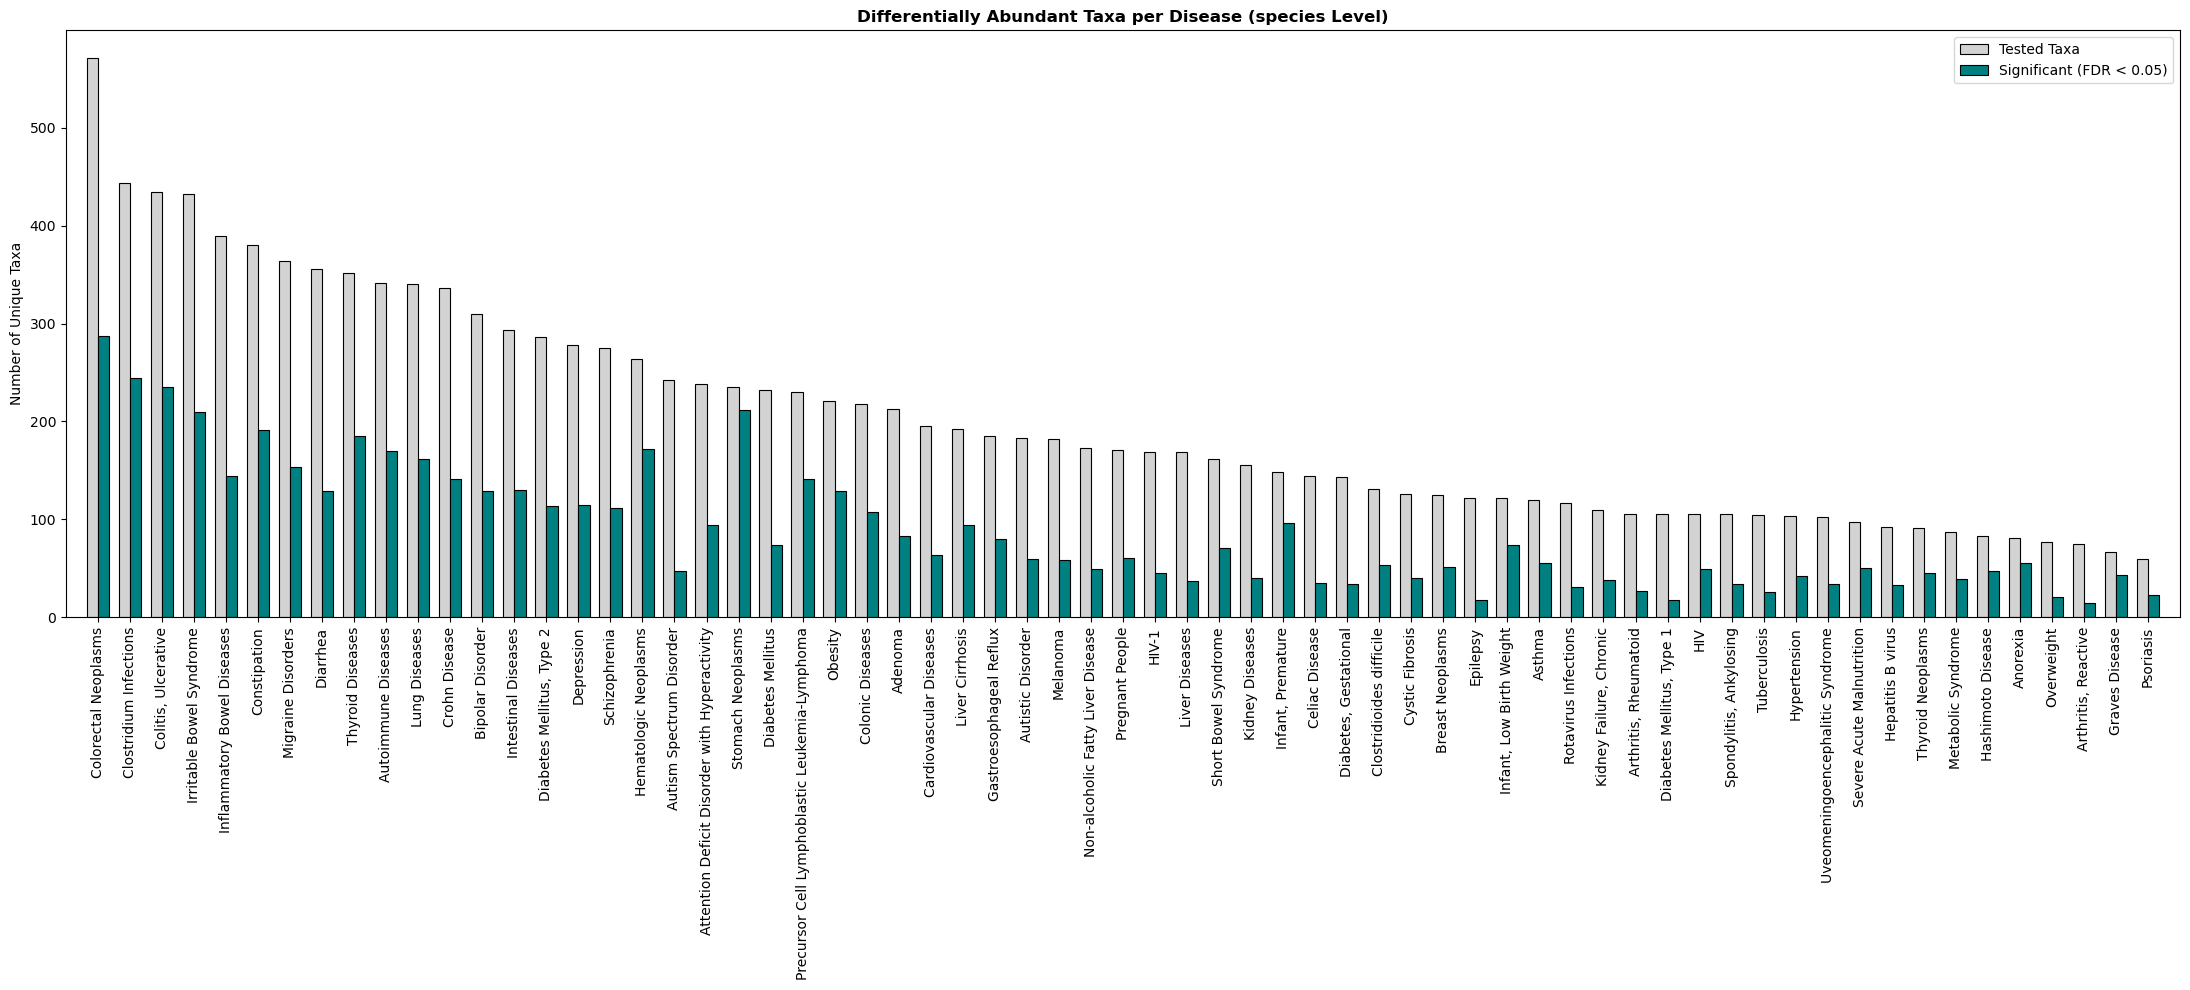

✅ PERMUTATION TESTING COMPLETE
• Total diseases tested: 65
• Total (disease, taxon) pairs tested: 13159
• Total significant pairs (FDR < 0.05): 5697
• Shape of df_species_significant: (819344, 4)
• Unique significant taxa: 1149
• Diseases with significant taxa: 65
📁 Saved significant species-level taxa to 'significant_species_taxa.txt'


,n_taxa_tested,n_significant
disease,,
D015179,571,287
D003015,444,244
D003093,434,235
D043183,432,210
D015212,389,144
...,...,...
D000855,81,55
D050177,77,21
D016918,75,15


,taxon,disease,p_value,mean_healthy,mean_disease,diff_mean,p_adj
3115,308994,D001321,0.000999,0.079933,1.339118,1.259186,0.003383
9072,39488,D008107,0.000999,0.387965,0.046814,-0.341151,0.003383
3139,1613,D012778,0.000999,0.002465,0.995642,0.993177,0.003383
3138,1596,D012778,0.000999,0.002599,1.428271,1.425672,0.003383
3133,562,D012778,0.000999,0.450688,3.359335,2.908647,0.003383
...,...,...,...,...,...,...,...
1759,437897,D015212,0.997003,0.019947,0.019856,-0.000091,1.000000
10769,72556,D002446,1.000000,0.000000,0.025500,0.025500,1.000000
47,292800,D003924,0.988012,0.235284,0.035901,-0.199383,1.000000
6154,215690,D003248,1.000000,0.000000,0.003466,0.003466,1.000000


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from tqdm.notebook import tqdm
import seaborn as sns

# ---------------------------
# Configuration
# ---------------------------
HEALTHY_CODE = "D006262"
N_PERMUTATIONS = 1000
RANDOM_SEED = 42

# ---------------------------
# Permutation Test Function
# ---------------------------
def permutation_test(x, y, num_permutations=N_PERMUTATIONS, stat_func=np.mean):
    observed = stat_func(y) - stat_func(x)
    combined = np.concatenate([x, y])
    count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_x = combined[:len(x)]
        new_y = combined[len(x):]
        perm_stat = stat_func(new_y) - stat_func(new_x)
        if abs(perm_stat) >= abs(observed):
            count += 1
    return (count + 1) / (num_permutations + 1)

# ---------------------------
# Prepare Data
# ---------------------------
disease_codes_species = df_species_retained['disease'].unique()
disease_codes_species = [d for d in disease_codes_species if d != HEALTHY_CODE]

healthy_df_species = df_species_retained[df_species_retained['disease'] == HEALTHY_CODE]
healthy_uids_species = healthy_df_species['loaded_uid'].unique()

# ---------------------------
# Run Permutation Testing
# ---------------------------
results_species = []
rng = np.random.default_rng(RANDOM_SEED)

for disease_code in tqdm(disease_codes_species, desc="Diseases", position=0):
    disease_df_species = df_species_retained[df_species_retained['disease'] == disease_code]
    disease_uids_species = disease_df_species['loaded_uid'].unique()
    disease_taxa_species = disease_df_species['ncbi_taxon_id'].unique()

    for taxon in tqdm(disease_taxa_species, desc=f"Taxa in {disease_code}", position=1, leave=False):
        disease_series = disease_df_species[disease_df_species['ncbi_taxon_id'] == taxon].set_index('loaded_uid')['relative_abundance']
        healthy_series = healthy_df_species[healthy_df_species['ncbi_taxon_id'] == taxon].set_index('loaded_uid')['relative_abundance']

        disease_vals = disease_series.reindex(disease_uids_species, fill_value=0).values
        healthy_vals = healthy_series.reindex(healthy_uids_species, fill_value=0).values

        # Skip if absent in both groups
        if np.all(disease_vals == 0) and np.all(healthy_vals == 0):
            continue

        # Skip if present in healthy but completely absent in disease
        if np.any(healthy_vals > 0) and np.all(disease_vals == 0):
            continue

        # Downsample to equal sample size
        if len(healthy_vals) > len(disease_vals):
            healthy_vals = rng.choice(healthy_vals, size=len(disease_vals), replace=False)
        elif len(disease_vals) > len(healthy_vals):
            disease_vals = rng.choice(disease_vals, size=len(healthy_vals), replace=False)

        # Run permutation test
        p_val = permutation_test(healthy_vals, disease_vals)

        # Store result
        results_species.append({
            'taxon': taxon,
            'disease': disease_code,
            'p_value': p_val,
            'mean_healthy': np.mean(healthy_vals),
            'mean_disease': np.mean(disease_vals),
            'diff_mean': np.mean(disease_vals) - np.mean(healthy_vals)
        })

# ---------------------------
# Process Results
# ---------------------------
results_df_species = pd.DataFrame(results_species)

if not results_df_species.empty:
    # FDR correction
    results_df_species['p_adj'] = multipletests(results_df_species['p_value'], method='fdr_bh')[1]

    # Summary Table
    summary_table_species = (
        results_df_species
        .groupby("disease")
        .agg(
            n_taxa_tested=("taxon", "nunique"),
            n_significant=("p_adj", lambda x: (x < 0.05).sum())
        )
        .sort_values("n_taxa_tested", ascending=False)
    )

    # ---------------------------
    # Plot with disease names
    # ---------------------------
    plot_df_species = summary_table_species.reset_index()
    plot_df_species['disease_name'] = plot_df_species['disease'].map(disease_dict).fillna(plot_df_species['disease'])
    plot_df_species = plot_df_species.sort_values("n_taxa_tested", ascending=False)

    plt.figure(figsize=(22, 10))
    x = np.arange(len(plot_df_species))
    width = 0.35

    plt.bar(x - width/2, plot_df_species['n_taxa_tested'], width=width, label='Tested Taxa',
            color='lightgrey', edgecolor='black', linewidth=0.8)
    plt.bar(x + width/2, plot_df_species['n_significant'], width=width, label='Significant (FDR < 0.05)',
            color='teal', edgecolor='black', linewidth=0.8)

    plt.xticks(x, plot_df_species['disease_name'], rotation=90)
    plt.ylabel("Number of Unique Taxa")
    plt.title("Differentially Abundant Taxa per Disease (species Level)", fontweight='bold')
    plt.legend()
    plt.margins(x=0.01)  # Reduce side padding
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # Create filtered sample-level data with only significant taxa
    # ---------------------------
    sig_taxa_species = results_df_species.query("p_adj < 0.05")[["disease", "taxon"]].drop_duplicates()
    df_species_significant = df_species_retained.merge(
        sig_taxa_species,
        left_on=["disease", "ncbi_taxon_id"],
        right_on=["disease", "taxon"],
        how="inner"
    ).drop(columns="taxon")

    # ---------------------------
    # Descriptive Summary
    # ---------------------------
    print("✅ PERMUTATION TESTING COMPLETE")
    print(f"• Total diseases tested: {len(summary_table_species)}")
    print(f"• Total (disease, taxon) pairs tested: {results_df_species.shape[0]}")
    print(f"• Total significant pairs (FDR < 0.05): {(results_df_species['p_adj'] < 0.05).sum()}")
    print(f"• Shape of df_species_significant: {df_species_significant.shape}")
    print(f"• Unique significant taxa: {df_species_significant['ncbi_taxon_id'].nunique()}")
    print(f"• Diseases with significant taxa: {df_species_significant['disease'].nunique()}")
    
    # ---------------------------
    # Save Significant Taxa Data
    # ---------------------------
    df_species_significant.to_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/microbiome_project/diff_taxa_abundance_analysis/significant_species_taxa.txt", sep="\t", index=False)
    print("📁 Saved significant species-level taxa to 'significant_species_taxa.txt'")  

    display(summary_table_species)
    display(results_df_species.sort_values("p_adj"))

else:
    print("⚠️ No valid taxa comparisons passed filtering.")


___
___
___

/tmp/slurm.4378198/ipykernel_2049084/816346268.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


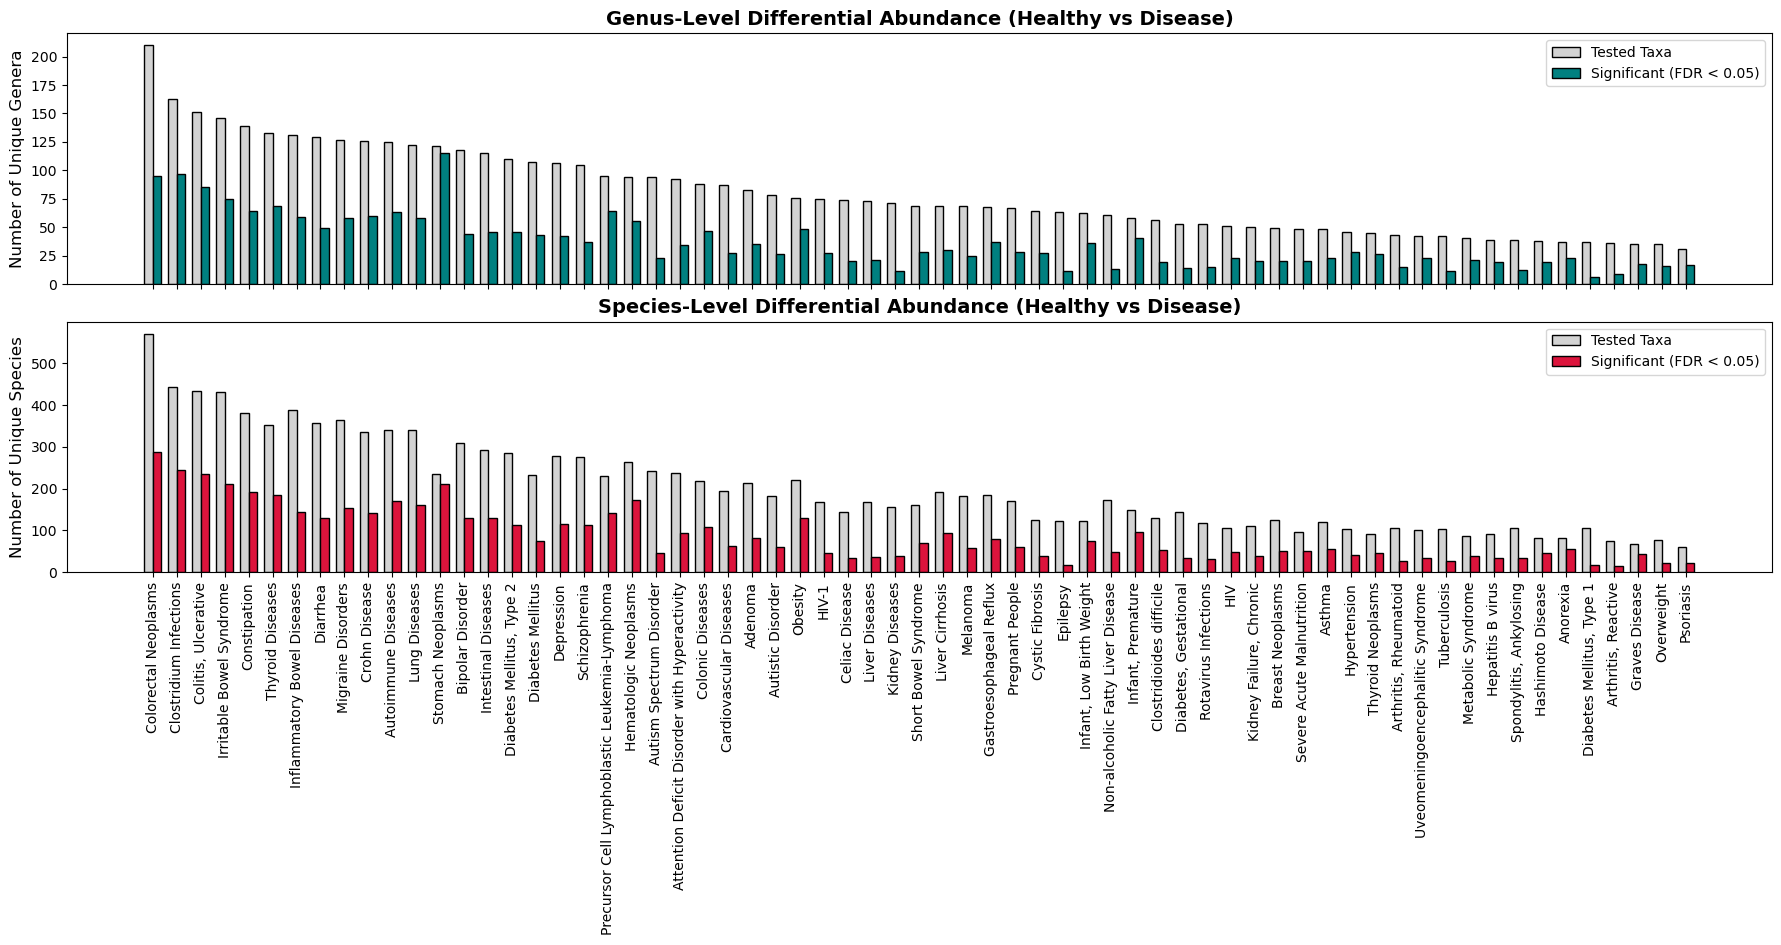

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# ---- Map disease codes to names and align order ----
summary_table_genus_plot = summary_table_genus.reset_index().copy()
summary_table_species_plot = summary_table_species.reset_index().copy()

summary_table_genus_plot['disease_name'] = summary_table_genus_plot['disease'].map(disease_dict).fillna(summary_table_genus_plot['disease'])
summary_table_species_plot['disease_name'] = summary_table_species_plot['disease'].map(disease_dict).fillna(summary_table_species_plot['disease'])

# ---- Sort by genus taxa tested (for consistent x-axis) ----
summary_table_genus_plot = summary_table_genus_plot.sort_values("n_taxa_tested", ascending=False)
sorted_diseases = summary_table_genus_plot['disease']

# ---- Reorder species table to match genus order ----
summary_table_species_plot['disease'] = pd.Categorical(summary_table_species_plot['disease'], categories=sorted_diseases, ordered=True)
summary_table_species_plot = summary_table_species_plot.sort_values("disease")

# ---- Plotting ----
x = np.arange(len(summary_table_genus_plot))
width = 0.35

fig, axs = plt.subplots(2, 1, figsize=(22, 7), sharex=True, gridspec_kw={'hspace': 0.15})

# === Genus-level plot ===
axs[0].bar(x - width/2, summary_table_genus_plot['n_taxa_tested'], width=width, label='Tested Taxa', color='lightgrey', edgecolor='black')
axs[0].bar(x + width/2, summary_table_genus_plot['n_significant'], width=width, label='Significant (FDR < 0.05)', color='teal', edgecolor='black')
axs[0].set_ylabel("Number of Unique Genera", fontsize=12)
axs[0].set_title("Genus-Level Differential Abundance (Healthy vs Disease)", fontweight='bold', fontsize=14)
axs[0].legend()

# === Species-level plot ===
axs[1].bar(x - width/2, summary_table_species_plot['n_taxa_tested'], width=width, label='Tested Taxa', color='lightgrey', edgecolor='black')
axs[1].bar(x + width/2, summary_table_species_plot['n_significant'], width=width, label='Significant (FDR < 0.05)', color='crimson', edgecolor='black')
axs[1].set_ylabel("Number of Unique Species", fontsize=12)
axs[1].set_title("Species-Level Differential Abundance (Healthy vs Disease)", fontweight='bold', fontsize=14)
axs[1].set_xticks(x)
axs[1].set_xticklabels(summary_table_genus_plot['disease_name'], rotation=90)
axs[1].legend()

plt.tight_layout()
plt.show()
